In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

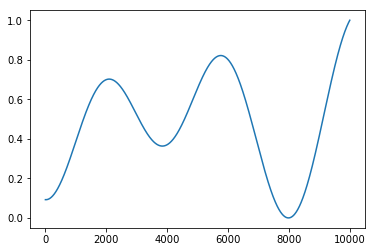

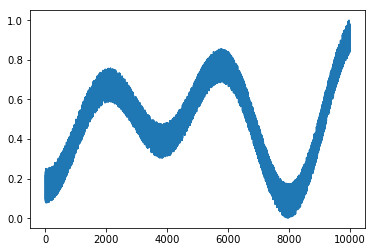

(1, 10000) (1, 10000)


In [113]:
e = np.random.rand(10000)
a = np.linspace(-5, 5, 10000)
x = np.cos(a + 0.75) + 1.6*np.sin(1.5*a)
x += np.abs(x.min())
y = x + e
x /= np.abs(x).max()
y /= np.abs(y).max()
plt.plot(x)
plt.show()
plt.plot(y)
plt.show()
x, y = x[None,:], y[None,:]
print(x.shape, y.shape)


In [131]:
class LSTM2RNN(nn.Module):
    def __init__(self, conv_in_channels, conv_out_features, ws, hs, rnn_hidden_size, rnn_output_size):
        super(LSTM2RNN, self).__init__()
        self.cin_channels = conv_in_channels
        self.cout_features = conv_out_features
        self.rnn_hid = rnn_hidden_size
        self.rnn_out = rnn_output_size
        
        
        # hard coding vars so I know what they are.
        n_layers = 2 # number of layers of RNN
        batch_size = 1
        kernel2d = 3
        # hidden initialization
        self.hidden = self.init_hidden(n_layers, batch_size, rnn_hidden_size)
        
        # net layer types
        self.c1 = nn.Conv1d(conv_in_channels, conv_out_features+kernel2d-1, ws, stride=hs)
        self.c2 = nn.Conv2d(1, conv_out_features, kernel2d)
        self.lstm = nn.LSTM(conv_out_features*conv_out_features, rnn_hidden_size, n_layers, 
                            batch_first=True, bidirectional=False)
        self.dense = nn.Linear(rnn_hidden_size, rnn_output_size)
        
    def forward(self, input):
        #print("input size: {}".format(input.size()))
        conv_out = self.c1(input)
        #print("conv1d out: {}".format(conv_out.size()))
        conv2_out = self.c2(conv_out.unsqueeze(0))
        #print("conv2d out: {}".format(conv2_out.size()))
        lstm_in = conv2_out.view(input.size(0), -1, self.cout_features * self.cout_features)
        #print("lstm in: {}".format(lstm_in.size()))
        self.hidden = self.repackage_hidden(self.hidden)
        lstm_out, self.hidden = self.lstm(lstm_in, self.hidden)
        #print("lstm out: {}".format(lstm_out.size()))
        dense_in = lstm_out.view(lstm_in.size(1)*input.size(0) ,-1)
        #print("dense in: {}".format(dense_in.size()))
        out_space = self.dense(dense_in)
        out = F.sigmoid(out_space)
        out = out.view(input.size(0), -1)
        return(out)
        
    def init_hidden(self, nl, bat_dim, hid_dim):
        # The axes: (num_layers, minibatch_size, hidden_dim)
        # see docs
        return (Variable(torch.zeros(nl, bat_dim, hid_dim)), 
                Variable(torch.zeros(nl, bat_dim, hid_dim)))
    
    def repackage_hidden(self, h):
        # will become state.detach_()
        if type(h[0]) == Variable:
            return((Variable(h[0].data),
                    Variable(h[1].data)))
        else:
            return(h)

class GRU2RNN(nn.Module):
    def __init__(self, conv_in_channels, conv_out_features, ws, hs, rnn_hidden_size, rnn_output_size):
        super(GRU2RNN, self).__init__()
        self.cin_channels = conv_in_channels
        self.cout_features = conv_out_features
        self.rnn_hid = rnn_hidden_size
        self.rnn_out = rnn_output_size
        
        # pad input
        self.pad = None
        
        # hard coding vars so I know what they are.
        n_layers = 2 # number of layers of RNN
        batch_size = 1
        kernel2d = 3
        # hidden initialization
        self.hidden = self.init_hidden(n_layers, batch_size, rnn_hidden_size)
        
        # net layer types
        self.c1 = nn.Conv1d(conv_in_channels, conv_out_features+kernel2d-1, ws, stride=hs)
        self.c2 = nn.Conv2d(1, conv_out_features, kernel2d)
        self.gru = nn.GRU(conv_out_features*conv_out_features, rnn_hidden_size, n_layers, 
                          batch_first=True, bidirectional=False)
        self.dense = nn.Linear(rnn_hidden_size, rnn_output_size)
        
    def forward(self, input):
        conv_out = F.relu(self.c1(input))
        conv2_out = F.relu(self.c2(conv_out.unsqueeze(0)))
        gru_in = conv2_out.view(input.size(0), -1, self.cout_features * self.cout_features)
        gru_out, self.hidden = self.gru(gru_in, self.hidden)
        dense_in = gru_out.view(gru_in.size(1)*input.size(0) ,-1)
        out_space = self.dense(dense_in)
        out = F.sigmoid(out_space)
        out = out.view(input.size(0), -1)
        return(out)
        
    def init_hidden(self, nl, bat_dim, hid_dim):
        # The axes: (num_layers, minibatch_size, hidden_dim)
        # see docs
        return (Variable(torch.zeros(nl, bat_dim, hid_dim)))    

ws = 400
hs = 50


model = LSTM2RNN(1, 64, ws, hs, 1024, hs)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

inputs = torch.from_numpy(y).float()
inputs.unsqueeze_(0)
front_pad = torch.zeros(inputs.size()[:-1] + tuple([hs*2]))
back_pad = torch.zeros(inputs.size()[:-1] + tuple([ws - hs]))
inputs_padded = torch.cat([front_pad, inputs, back_pad], dim=2)
targets = torch.from_numpy(x).float()
print(inputs.size(), targets.size())
print(model)
print(model(Variable(inputs_padded)))
print(inputs_padded.min(), inputs_padded.max())

torch.Size([1, 1, 10000]) torch.Size([1, 10000])
LSTM2RNN (
  (c1): Conv1d(1, 66, kernel_size=(400,), stride=(50,))
  (c2): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (lstm): LSTM(4096, 1024, num_layers=2, batch_first=True)
  (dense): Linear (1024 -> 50)
)
Variable containing:
 0.4984  0.4986  0.5062  ...   0.5049  0.4939  0.5066
[torch.FloatTensor of size 1x10000]

0.0 1.0


Loss of 2.0338919162750244 @ epoch 1


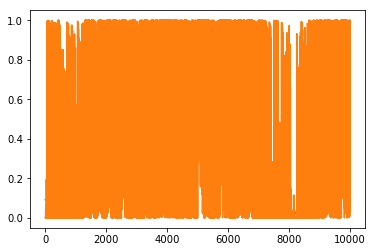

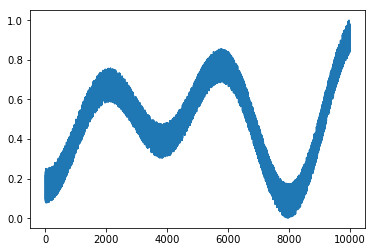

Loss of 0.8082036972045898 @ epoch 11


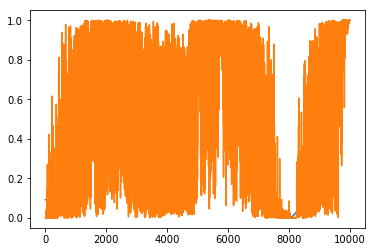

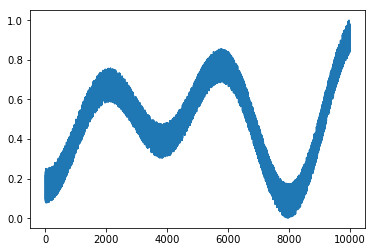

Loss of 0.6808843612670898 @ epoch 21


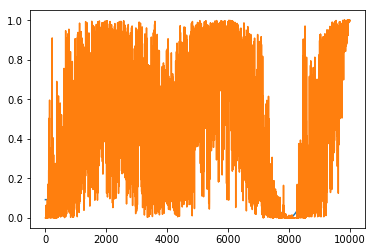

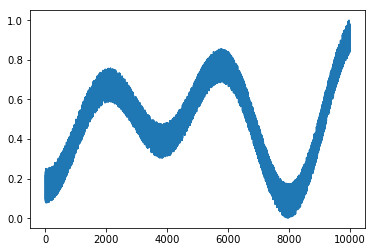

Loss of 0.637233316898346 @ epoch 31


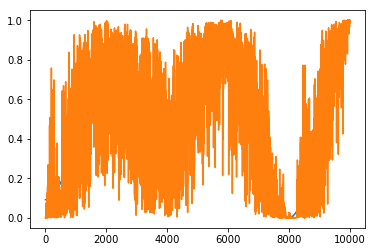

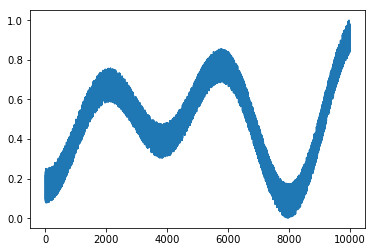

Loss of 0.6059238910675049 @ epoch 41


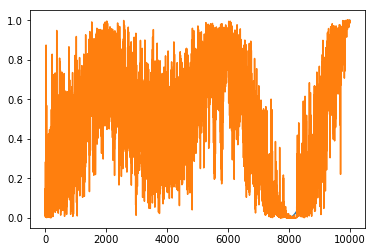

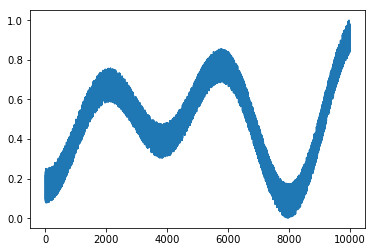

Loss of 0.5909314155578613 @ epoch 51


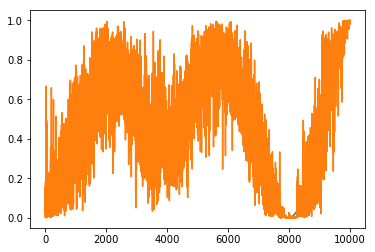

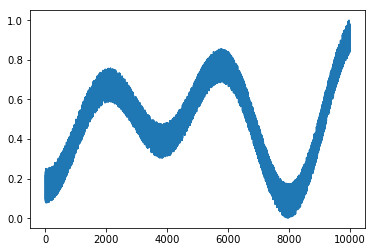

In [134]:
n_layers = 2 # number of layers of RNN
batch_size = 1
kernel2d = 3

epochs = 51

#optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-3, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


for epoch in range(epochs):
    for mb, tgts in zip(inputs_padded, targets):
        mb.unsqueeze_(0)
        model.zero_grad()
        optimizer.zero_grad()
        model.init_hidden(n_layers, batch_size, hs)
        mb = Variable(mb)
        l = Variable(tgts.unsqueeze(0))
        o = model(mb)
        loss = criterion(o, l)
        loss.backward()
        #nn.utils.clip_grad_norm(model.parameters(), 0.75)
        optimizer.step()
        if epoch % 10 == 0:
            print("Loss of {} @ epoch {}".format(loss.data[0], epoch+1))
            plt.plot(x.ravel())
            plt.plot(o.data.numpy().ravel())
            plt.show()
            plt.plot(y.ravel())
            plt.show()



(1, 10000)


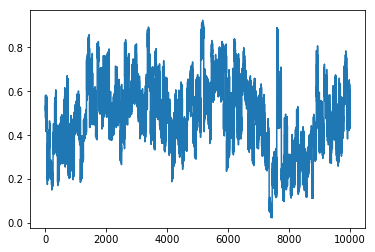

In [123]:
out = model(Variable(inputs_padded))
#out.squeeze_()
out = out.data.numpy()
print(out.shape)
plt.plot(out.ravel())